## Chapter 24 - Count Predicted Variable

- [24.2 - Example: Hair Eye Go Again](#24.2---Example:-Hair-Eye-Go-Again)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import mode, norm
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

### 24.2 - Example: Hair Eye Go Again

#### Data

In [3]:
df = pd.read_csv('data/HairEyeColor.csv', dtype={'Hair':'category', 'Eye':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
Hair     16 non-null category
Eye      16 non-null category
Count    16 non-null int64
dtypes: category(2), int64(1)
memory usage: 304.0 bytes


In [4]:
df['Prop'] = df.Count.apply(lambda x: x/df.Count.sum())
df.head()

,Hair,Eye,Count,Prop
0,Black,Blue,20,0.033784
1,Black,Brown,68,0.114865
2,Black,Green,5,0.008446
3,Black,Hazel,15,0.025338
4,Blond,Blue,94,0.158784


In [5]:
df_pivot = df.pivot('Eye', 'Hair')
df_pivot

Count                      Prop                              
Hair  Black Blond Brown Red     Black     Blond     Brown       Red
Eye                                                                
Blue     20    94    84  17  0.033784  0.158784  0.141892  0.028716
Brown    68     7   119  26  0.114865  0.011824  0.201014  0.043919
Green     5    16    29  14  0.008446  0.027027  0.048986  0.023649
Hazel    15    10    54  14  0.025338  0.016892  0.091216  0.023649

#### Model (Kruschke, 2015)

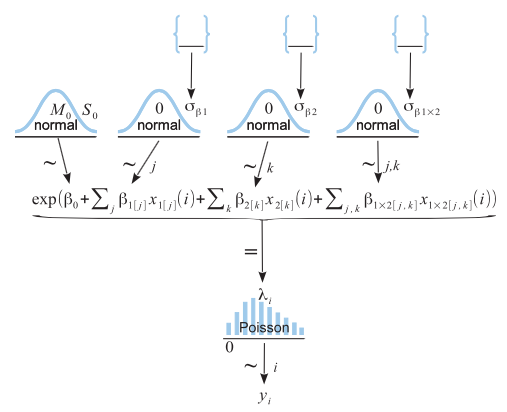

In [6]:
Image('images/fig24_2.png')

In [8]:
y = df.Count
x1 = df.Eye.cat.codes
x2 = df.Hair.cat.codes
Nx1Lvl = len(df.Eye.cat.categories)
Nx2Lvl = len(df.Hair.cat.categories)
Ncell = df.Count.size

yLogMean = np.log(np.sum(y)/(Nx1Lvl*Nx2Lvl))
yLogSD = np.log(np.std(np.r_[np.repeat([0], Ncell-1), np.sum(y)], ddof=1))
agammaShRa = gammaShRaFromModeSD(yLogSD, 2*yLogSD)

with pm.Model() as poisson_model:
        a0 = pm.Normal('a0', yLogMean, tau=1/(yLogSD*2)**2)

        a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
        a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
        
        a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
        a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
        
        a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
        a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
        lmbda = pm.exp(a0 + a1[x1] + a2[x2] +a1a2[x1, x2])
        
        y = pm.Poisson('y', lmbda, observed=y)

Applied log-transform to a1SD and added transformed a1SD_log_ to model.
Applied log-transform to a2SD and added transformed a2SD_log_ to model.
Applied log-transform to a1a2SD and added transformed a1a2SD_log_ to model.


In [13]:
n_samples = 10000
with poisson_model:
    trace1 = pm.sample(n_samples)

Assigned NUTS to a0
Assigned NUTS to a1SD_log_
Assigned NUTS to a1
Assigned NUTS to a2SD_log_
Assigned NUTS to a2
Assigned NUTS to a1a2SD_log_
Assigned NUTS to a1a2
 [-----------------100%-----------------] 10000 of 10000 complete in 579.5 sec

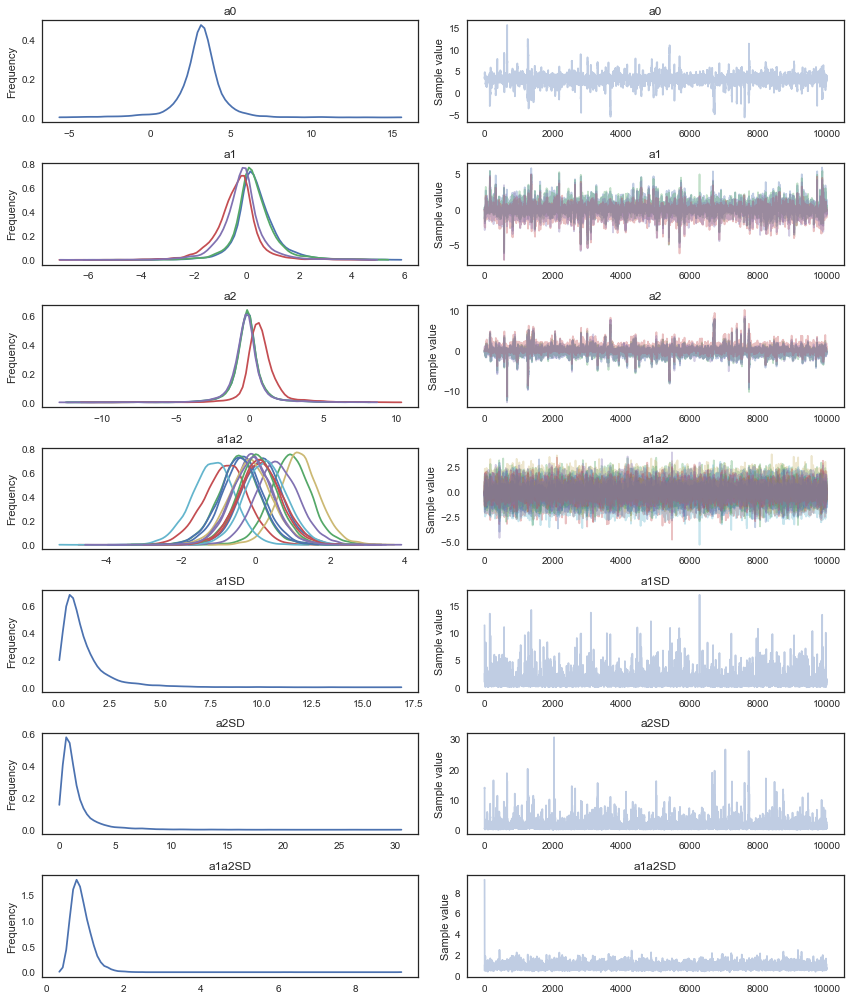

In [14]:
pm.traceplot(trace1);

In [15]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Compute predicted proportions
expm = np.exp(m)
ppx1x2p = expm/np.sum(expm, axis=(0,1))

ppx1p = np.sum(ppx1x2p, axis=(0,1))
ppx2p = np.sum(ppx1x2p, axis=(1,0))

#### Figure 24.3
It is best to plot the histograms of estimated cell proporations on the same range to get an idea of their differences. However, the HPD bounderies do not display well for very narrow hpd's (the values overlap).

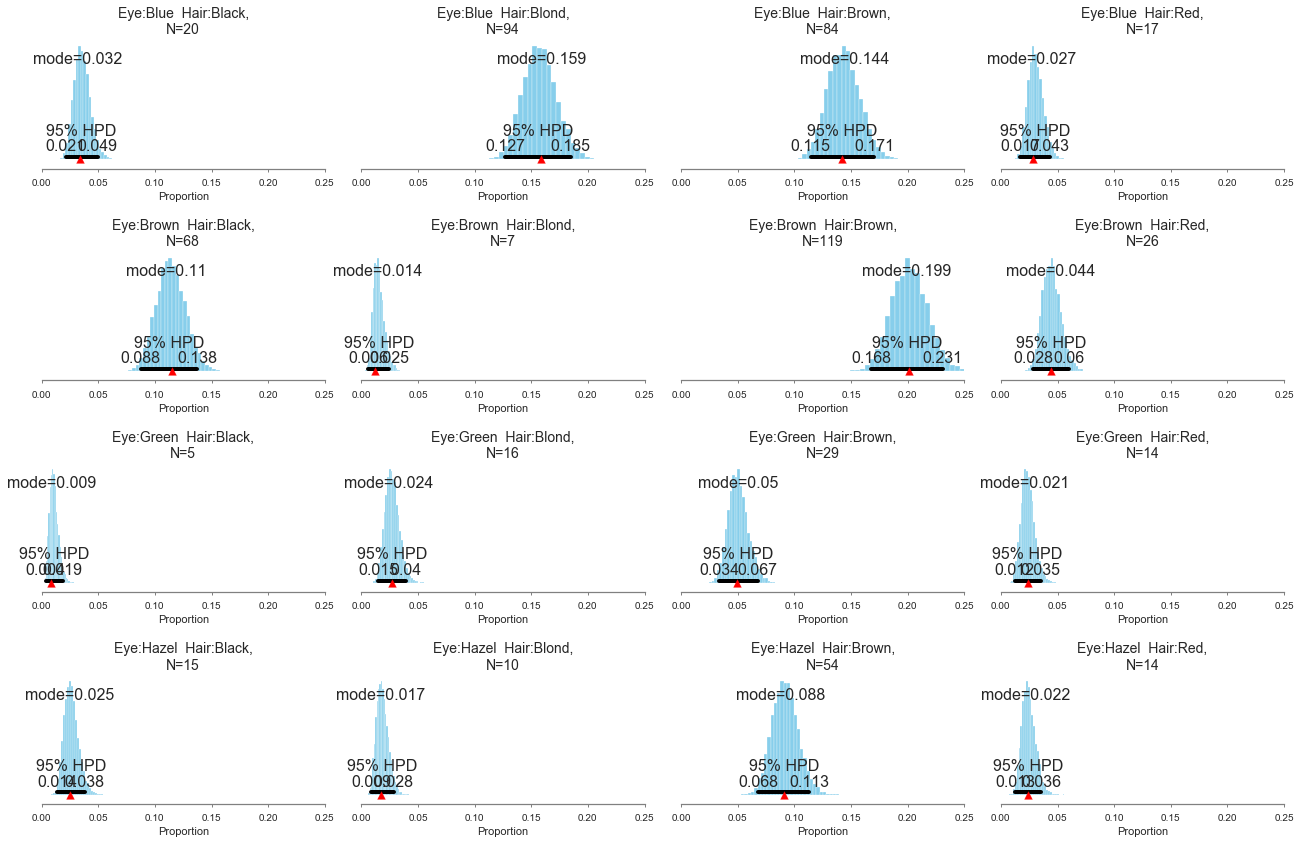

In [26]:
burnin = 250

# Define gridspec
fig, axes = plt.subplots(4,4, figsize=(18,12))
for (r, c), ax in np.ndenumerate(axes):
    ax = pm.plot_posterior(ppx1x2p[r,c,:][burnin:], point_estimate='mode', color=color, ax=ax)
    ax.scatter(df_pivot['Prop'].iloc[r,c], 0, s=60, c='r', marker='^', zorder=5)
    ax.set_title('Eye:{}  Hair:{},\nN={}'.format(df_pivot.index[r],
                                                df_pivot['Count'].columns[c],
                                                df_pivot['Count'].iloc[r,c]),
                 fontdict=f_dict)
    ax.set_xlim(left=.0, right=.25)
    ax.set_xlabel('Proportion')
fig.tight_layout(pad=1.7);